In [1]:
from itertools import chain
from collections import OrderedDict

from adult import AdultRaw, Adult
import dill
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, truncnorm, multinomial, beta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm

from probspecs import (
    MultivariateIndependent,
    UnivariateContinuousDistribution,
    MixtureModel,
    CategoricalOneHot,
    TensorInputSpace,
    TabularInputSpace,
)
from probspecs.population_models import (
    FactorAnalysisModel,
    EncodeOneHot,
    Normalize,
    Denormalize,
    Identity,
)

from input_spaces import adult_input_space

torch.manual_seed(353710130163567)
np.random.seed(2548400)

/home/david/.miniconda3/envs/prob-specs/lib/python3.10/site-packages/torch/utils/cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


# Dataset Overview


In [2]:
# dataset is with one-hot encodings and normalisation,
# dataset_raw is without.
dataset = Adult(root="../../.datasets", download=True)
test_set = Adult(root="../../.datasets", train=False, download=True)
dataset_raw = AdultRaw(root="../../.datasets", download=True)
test_data_raw = AdultRaw(root="../../.datasets", train=False, download=True)

## Marginal Distributions

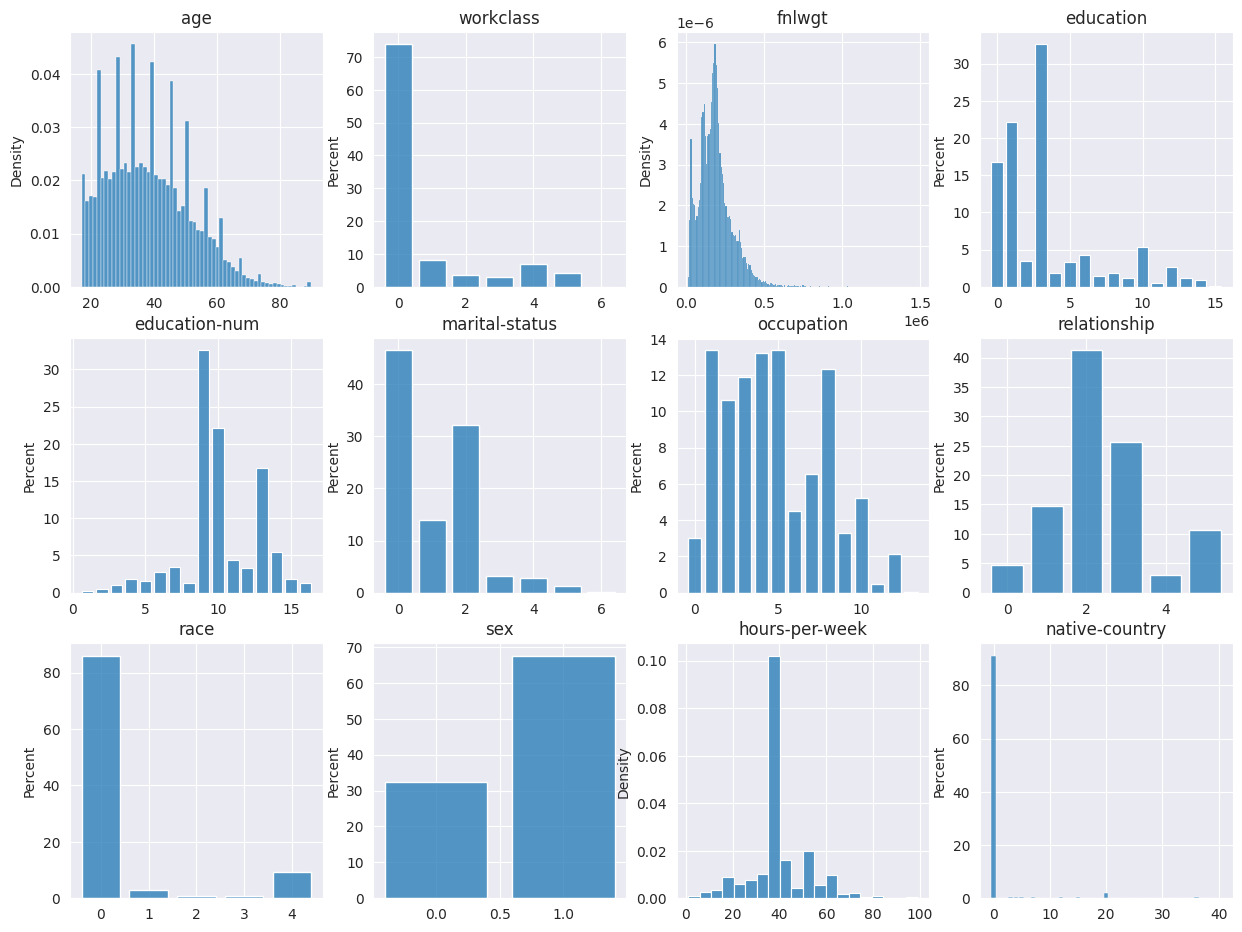

In [3]:
%%capture --no-stdout --no-display
data_df = pd.DataFrame(dataset_raw.data, columns=dataset_raw.columns)

fig, axes = plt.subplots(3, 4, figsize=(15, 11.25))
axes = axes.flatten()
vars = [
    var for var in adult_input_space.attribute_names if not var.startswith("capital")
]
for var, ax in zip(vars, axes):
    ax.set_title(var)
    # categorical variables
    if var in (
        "workclass",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ):
        g = sns.histplot(
            data_df,
            x=var,
            discrete=True,
            shrink=0.8,
            multiple="dodge",
            stat="percent",
            ax=ax,
        )
    else:
        kwargs = {}
        if var == "hours-per-week":
            kwargs["bins"] = 20
        g = sns.histplot(
            data_df,
            x=var,
            stat="density",
            ax=ax,
            **kwargs,
        )
    g.set(xlabel=None)

Changes in capital are split in the dataset across the variables "capital-gain" and "capital-loss".
Here, capital-loss is zero whenever capital-gain is greater zero and the other way around.
We summarize the two values in a single additional variable "capital-change".

**Note the logarithmic scale on the y axis in the plot below**.


<Axes: title={'center': 'Capital Loss'}, xlabel='capital-loss', ylabel='Density'>

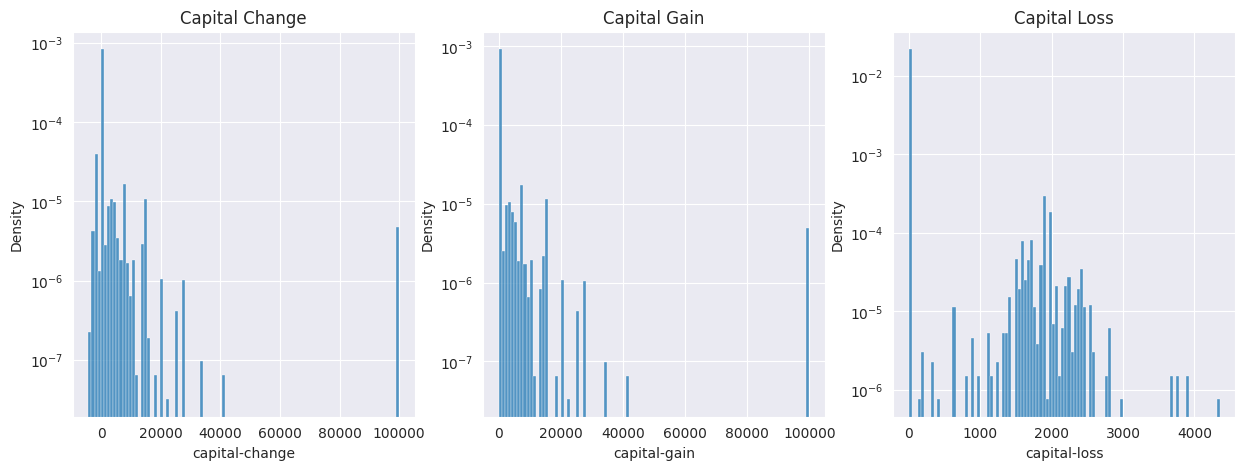

In [4]:
%%capture --no-stdout --no-display
data_df["capital-change"] = data_df["capital-gain"] - data_df["capital-loss"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].set_title("Capital Change")
sns.histplot(
    data_df,
    x="capital-change",
    stat="density",
    log_scale=(False, True),
    bins=100,
    ax=axes[0],
)

axes[1].set_title("Capital Gain")
sns.histplot(
    data_df,
    x="capital-gain",
    stat="density",
    log_scale=(False, True),
    bins=100,
    ax=axes[1],
)

axes[2].set_title("Capital Loss")
sns.histplot(
    data_df,
    x="capital-loss",
    stat="density",
    log_scale=(False, True),
    bins=100,
    ax=axes[2],
)

## Relationships between Variables
### Selected Relationships


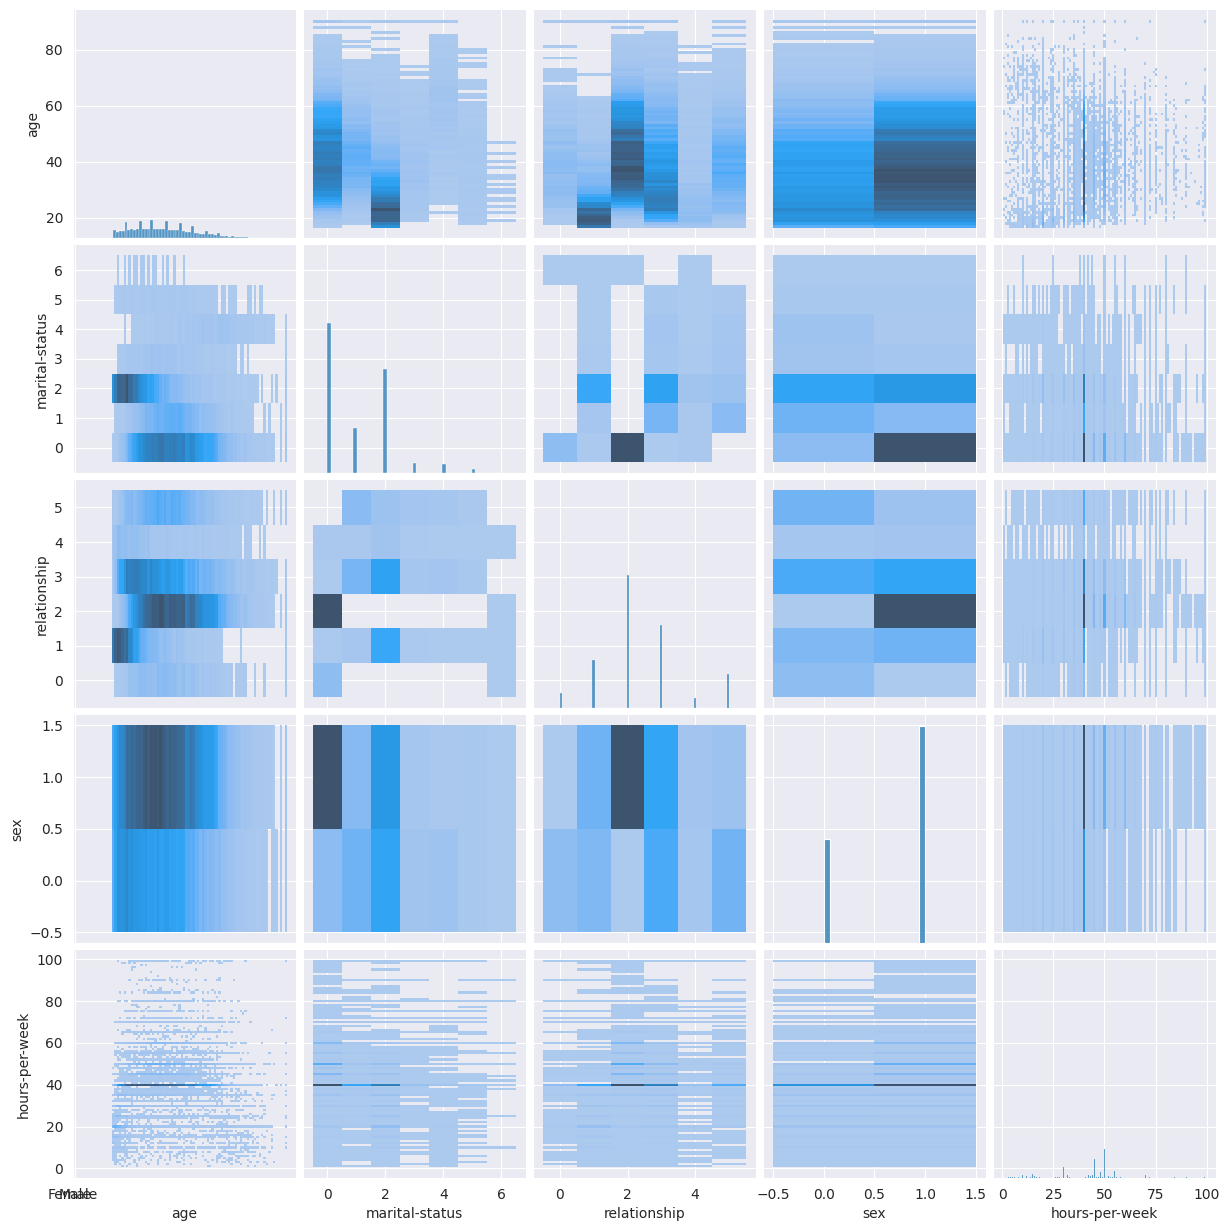

In [5]:
%%capture --no-stdout --no-display
g = sns.pairplot(
    data_df,
    vars=("age", "marital-status", "relationship", "sex", "hours-per-week"),
    kind="hist",
    plot_kws={"bins": 25, "discrete": True},
)
g.axes[3][0].set_xticks([0, 1], ("Female", "Male"))


### Correlation Heatmap


<Axes: >

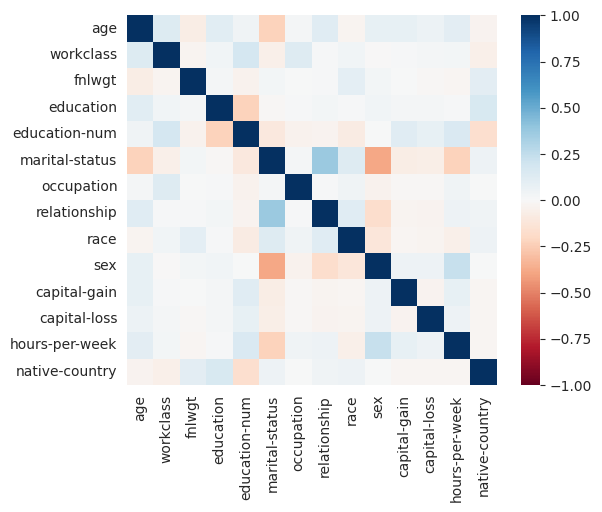

In [6]:
sns.heatmap(
    torch.corrcoef(dataset_raw.data.T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
)

# Population Models
## General Utilities


In [7]:
col_idx = {
    var: [
        i
        for i, col in enumerate(dataset.columns)
        if col == var or col.startswith(f"{var}=")
    ]
    for var in adult_input_space.attribute_names
}
col_idx["capital-change"] = [-1]
col_raw_id = {  # for accessing non-one-hot-encoded categorical variables
    var: dataset_raw.columns.index(var) for var in adult_input_space.attribute_names
}
col_id_input_space = {var: i for i, var in enumerate(adult_input_space.attribute_names)}


def _get_mean_std_min_max(data_, var=None, var_min=None, var_max=None):
    if var_min is not None:
        min_, max_ = var_min, var_max
    elif var is not None:
        min_, max_ = adult_input_space.attribute_bounds(col_id_input_space[var])
    else:
        raise ValueError("var and var_min/var_max may not both be None.")
    mean_ = data_.mean().item()
    std_ = data_.std().item()
    return mean_, std_, min_, max_


def make_truncnorm(data_, var=None, var_min=None, var_max=None):
    mean_, std_, min_, max_ = _get_mean_std_min_max(data_, var, var_min, var_max)
    # truncnorm needs min_ and max_ to be the number of standard deviations from loc
    min_ = (min_ - mean_) / std_
    max_ = (max_ - mean_) / std_
    return truncnorm(a=min_, b=max_, loc=mean_, scale=std_)


def make_gaussian_mixture(data_, n_components, n_restarts=5):
    mixture_model = GaussianMixture(
        n_components,
        covariance_type="spherical",
        n_init=n_restarts,
    )
    mixture_model.fit(data_)
    return mixture_model


def make_categorical(data_one_hot_):
    class_frequencies = data_one_hot_.mean(dim=0).tolist()
    return multinomial(n=1, p=class_frequencies)


## Independent Population Model
Only model the variables separately, disregarding interactions between
variables. 
Note that under this assumption, a classifier can achieve fairness simply
by disregarding the sensitive attribute.
Therefore, the independent population model is only for testing purposes.

### Distributions
We fit Multinouli distributions to all categorical variables.

#### Categorical Variables


In [8]:
distributions = {
    "workclass": make_categorical(dataset.data[:, col_idx["workclass"]]),
    "education": make_categorical(dataset.data[:, col_idx["education"]]),
    "marital-status": make_categorical(dataset.data[:, col_idx["marital-status"]]),
    "occupation": make_categorical(dataset.data[:, col_idx["occupation"]]),
    "relationship": make_categorical(dataset.data[:, col_idx["relationship"]]),
    "race": make_categorical(dataset.data[:, col_idx["race"]]),
    "sex": make_categorical(dataset.data[:, col_idx["sex"]]),
    "native-country": make_categorical(dataset.data[:, col_idx["native-country"]]),
}


In [9]:
n = 10000
generated_raw = {}
for var in distributions:
    values_one_hot = distributions[var].rvs(size=n)
    values = np.argmax(values_one_hot, axis=1)
    generated_raw[var] = values


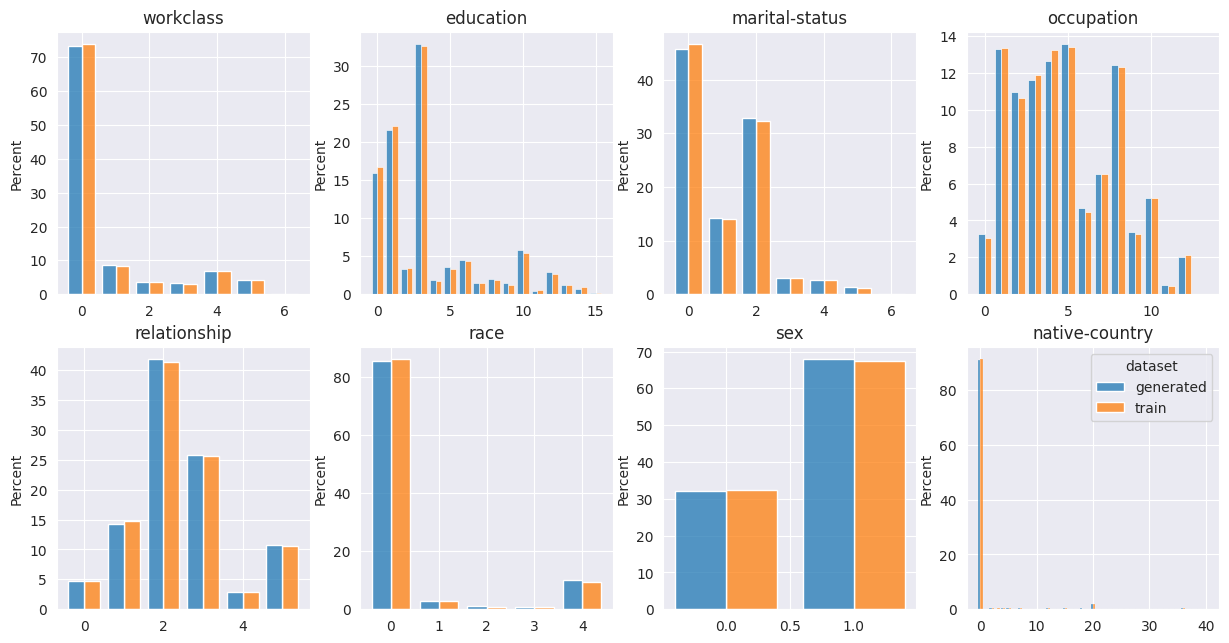

In [10]:
%%capture --no-stdout --no-display
generated_df = pd.DataFrame(generated_raw)
generated_df["dataset"] = "generated"
data_df["dataset"] = "train"
df = pd.concat([generated_df, data_df])

fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes = axes.flatten()
for var, ax in zip(distributions.keys(), axes):
    ax.set_title(var)
    g = sns.histplot(
        df,
        x=var,
        hue="dataset",
        discrete=True,
        shrink=0.8,
        multiple="dodge",
        stat="percent",
        common_norm=False,
        ax=ax,
        legend=var == "native-country",
    )
    g.set(xlabel=None)


#### Continuous Variables

For the continuous variables, we use
- age: truncated Normal distribution
- fnlwght: Beta distribution
- education-num: Multinouli distribution (as there are few values)
- hours-per-week: Gaussian Mixture Model with three Gaussians
- capital-gain: Gaussian Mixture Model
- capital-loss: Gaussian Mixture Model

##### Age


In [11]:
age_min, age_max = adult_input_space.attribute_bounds(col_id_input_space["age"])
age_loc = 32.0
age_scale = 18.0
distributions["age"] = truncnorm(
    a=(age_min - age_loc) / age_scale,
    b=(age_max - age_loc) / age_scale,
    loc=age_loc,
    scale=age_scale,
)


<Axes: xlabel='age', ylabel='Density'>

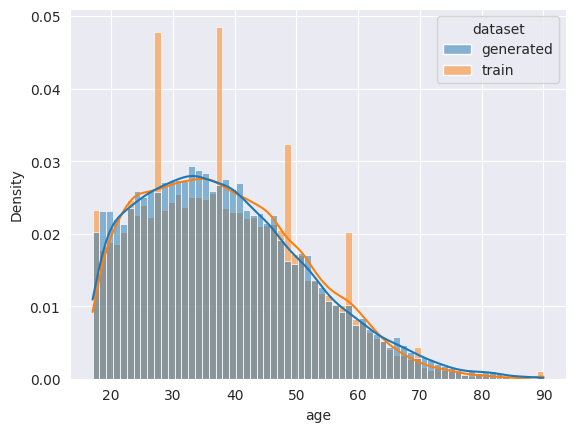

In [12]:
%%capture --no-stdout --no-display
age_data = distributions["age"].rvs(size=n)

generated_df["age"] = age_data
df = pd.concat([generated_df, data_df])

sns.histplot(
    df, x="age", hue="dataset", stat="density", common_norm=False, kde=True
)


##### fnlwgt


In [13]:
fnlwgt_min, fnlwgt_max = adult_input_space.attribute_bounds(col_id_input_space["fnlwgt"])
# The beta distribution produces values between 0.0 and 1.0. 
# Therefore, we want to move 0.0 to fnlwgt_min and 1.0 to fnlwgt_max
fnlwgt_loc = fnlwgt_min
fnlwgt_scale = fnlwgt_max
distributions["fnlwgt"] = beta(
    a=4.25,
    b=30.0,
    loc=fnlwgt_loc,  
    scale=fnlwgt_scale,
)


<Axes: xlabel='fnlwgt', ylabel='Density'>

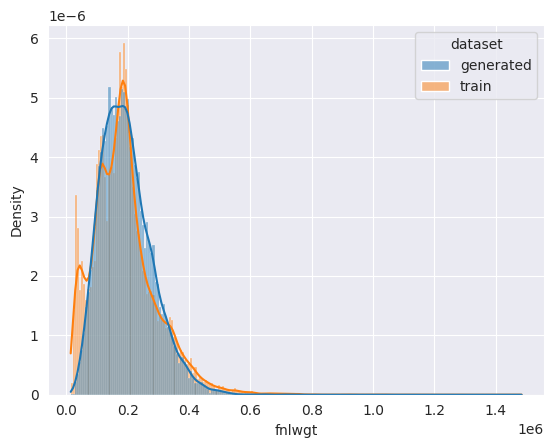

In [14]:
%%capture --no-stdout --no-display
fnlwgt_data = distributions["fnlwgt"].rvs(size=n)

generated_df["fnlwgt"] = fnlwgt_data
df = pd.concat([generated_df, data_df])


sns.histplot(
    df, x="fnlwgt", hue="dataset", stat="density", common_norm=False, kde=True
)


##### education-num


In [15]:
edu_num_data = dataset_raw.data[:, col_raw_id["education-num"]].int().numpy()
edu_num_num_values = edu_num_data.max() + 1
edu_num_one_hot = np.identity(edu_num_num_values)[edu_num_data]
edu_num_one_hot = torch.as_tensor(edu_num_one_hot)
distributions["education-num"] = make_categorical(edu_num_one_hot)


<Axes: xlabel='education-num', ylabel='Percent'>

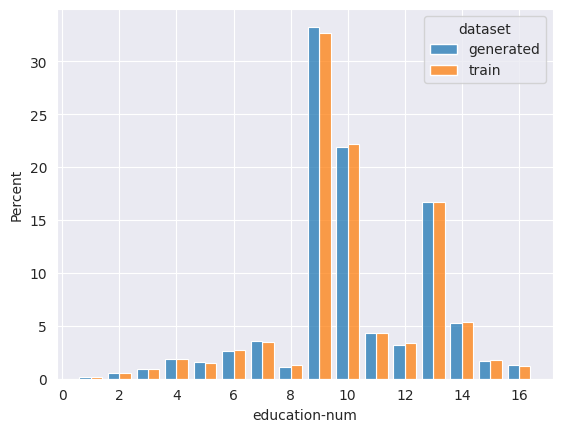

In [16]:
%%capture --no-stdout --no-display
edu_num_one_hot = distributions["education-num"].rvs(size=n)
edu_num_data = np.argmax(edu_num_one_hot, axis=1)

generated_df["education-num"] = edu_num_data
df = pd.concat([generated_df, data_df])

sns.histplot(
    df,
    x="education-num",
    hue="dataset",
    discrete=True,
    shrink=0.8,
    multiple="dodge",
    stat="percent",
    common_norm=False,
    legend=True
)


##### hours-per-week


In [17]:
work_hours_data = dataset_raw.data[:, col_raw_id["hours-per-week"]]
work_hours_data = work_hours_data.reshape(-1, 1)
mixture_model = make_gaussian_mixture(work_hours_data, n_components=3)
distributions["hours-per-week"] = mixture_model


<Axes: xlabel='hours-per-week', ylabel='Density'>

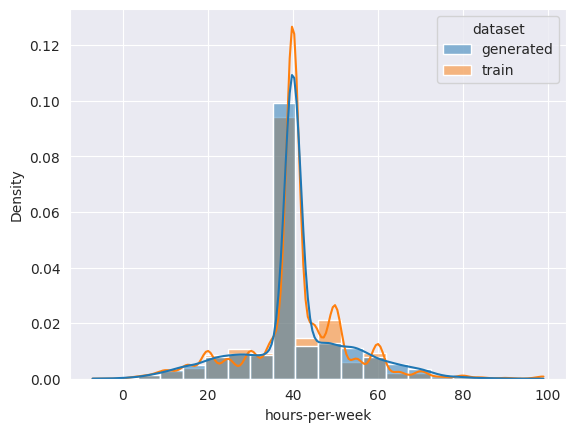

In [18]:
%%capture --no-stdout --no-display
work_hours_data, _ = distributions["hours-per-week"].sample(n)

generated_df["hours-per-week"] = work_hours_data.reshape(-1)
df = pd.concat([generated_df, data_df])

sns.histplot(
    df, 
    x="hours-per-week", 
    hue="dataset", 
    stat="density", 
    common_norm=False, 
    kde=True,
    bins=20,
)


##### capital-gain


In [19]:
capital_gain_data = dataset_raw.data[:, col_raw_id["capital-gain"]]
capital_gain_data = capital_gain_data.reshape(-1, 1)
mixture_model = make_gaussian_mixture(capital_gain_data, n_components=5)
distributions["capital-gain"] = mixture_model


<Axes: xlabel='capital-gain', ylabel='Density'>

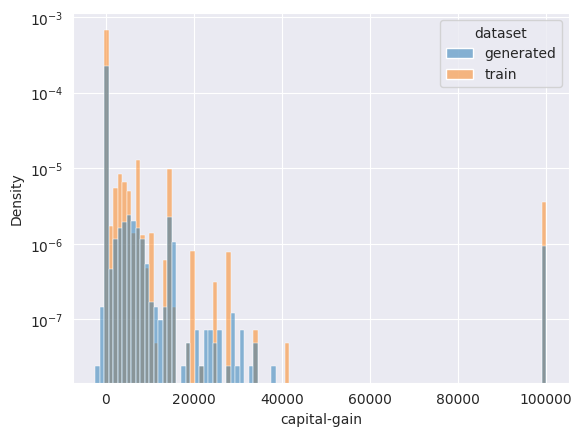

In [20]:
%%capture --no-stdout --no-display
capital_gain_data, _ = distributions["capital-gain"].sample(n)

generated_df["capital-gain"] = capital_gain_data.reshape(-1)
df = pd.concat([generated_df, data_df])

sns.histplot(
    df,
    x="capital-gain",
    hue="dataset",
    stat="density",
    log_scale=(False, True),
    bins=100,
)


##### capital-loss


In [21]:
capital_loss_data = dataset_raw.data[:, col_raw_id["capital-loss"]]
capital_loss_data = capital_loss_data.reshape(-1, 1)
mixture_model = make_gaussian_mixture(capital_loss_data, n_components=3)
distributions["capital-loss"] = mixture_model


<Axes: xlabel='capital-loss', ylabel='Density'>

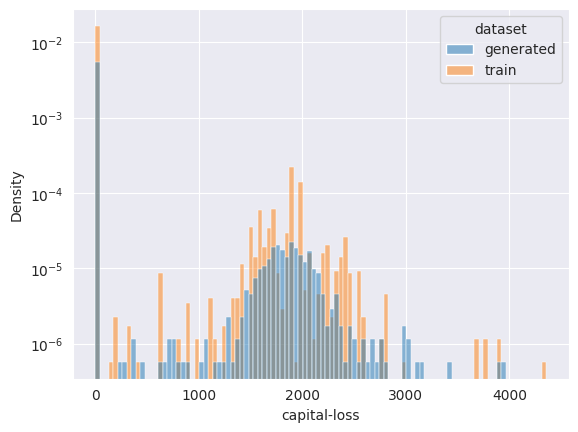

In [22]:
%%capture --no-stdout --no-display
capital_loss_data, _ = distributions["capital-loss"].sample(n)

generated_df["capital-loss"] = capital_loss_data.reshape(-1)
df = pd.concat([generated_df, data_df])

sns.histplot(
    df,
    x="capital-loss",
    hue="dataset",
    stat="density",
    log_scale=(False, True),
    bins=100,
)



### Compare Correlation Matrices
Just to remind ourselves that this is the *independent* population model,
that is, all the variables are independent.


<Axes: title={'center': 'Training Data'}>

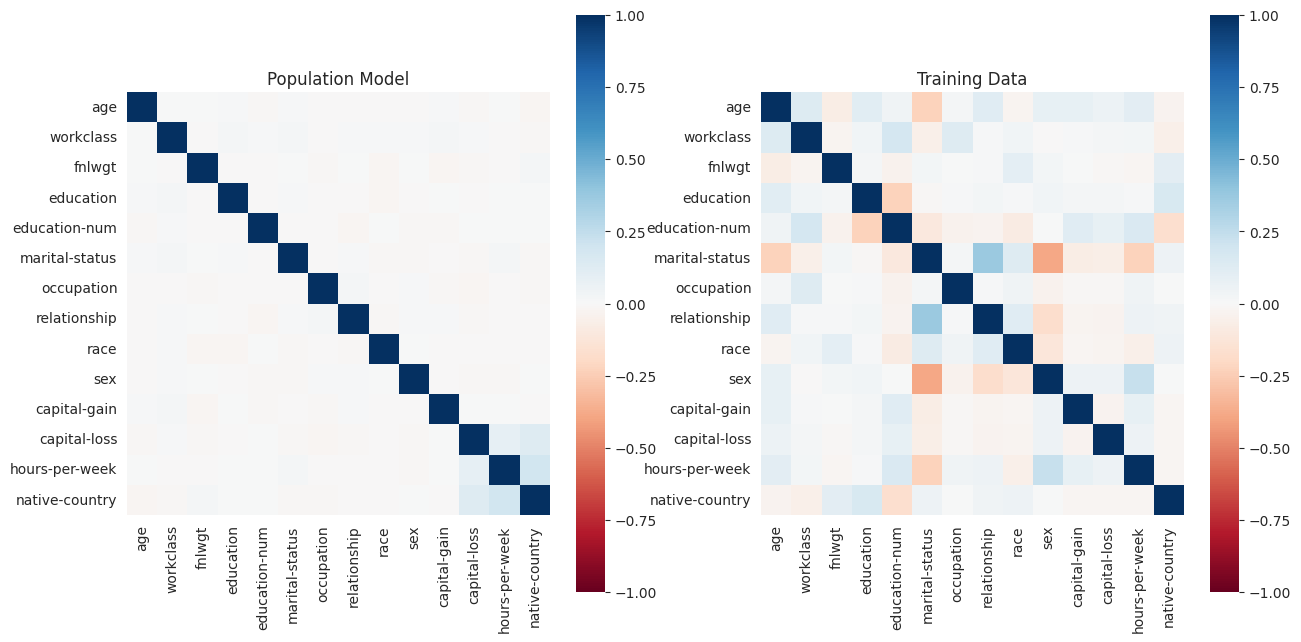

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))

axes[0].set_title("Population Model")
generated_df_ = generated_df.drop("dataset", axis=1)
sns.heatmap(
    np.corrcoef(generated_df_.to_numpy().T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
    ax=axes[0],
)
axes[1].set_title("Training Data")
sns.heatmap(
    torch.corrcoef(dataset_raw.data.T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
    ax=axes[1],
)


### Export Population Model

We need to export the probability distribution and a description of the space 
of values that are produced by the probability distribution.
Additionally, the values of the continuous attributes need to be normalized before 
being fed to a classifier.
The multinomial distributions already produce one-hot encoded attributes.
However, this means that `education-num` is also one-hot encoded and needs
to be converted to a single column.
We perform both normalization and converting `education-num` using a linear
neural network layer.


In [11]:
# Input Space
var_types = dict(zip(adult_input_space.attribute_names, adult_input_space.attribute_types))
var_types["education-num"] = TabularInputSpace.AttributeType.CATEGORICAL
categorical_values = {
    var: adult_input_space.attribute_values(i)
    for i, var in enumerate(adult_input_space.attribute_names)
    if adult_input_space.attribute_type(i) is TabularInputSpace.AttributeType.CATEGORICAL
}
categorical_values["education-num"] = [str(i) for i in range(edu_num_num_values)]
continuous_ranges = {
    var: adult_input_space.attribute_bounds(i)
    for i, var in enumerate(adult_input_space.attribute_names)
    if (
            adult_input_space.attribute_type(i) is TabularInputSpace.AttributeType.CONTINUOUS
            and var != "education-num"
    )
}
ind_input_space = TabularInputSpace(
    attributes=adult_input_space.attribute_names,
    data_types=var_types,
    continuous_ranges=continuous_ranges,
    ordinal_ranges={},
    categorical_values=categorical_values,
)

# Distribution
def convert_distribution(var):
    distribution = distributions[var]
    if isinstance(distribution, GaussianMixture):
        bounds = ind_input_space.attribute_bounds(var)
        return MixtureModel.from_gaussian_mixture(distribution, bounds)
    elif hasattr(distribution, "p") and hasattr(distribution, "n"):  # multinomial
        return CategoricalOneHot(torch.as_tensor(distribution.p))
    else:
        bounds = ind_input_space.attribute_bounds(var)
        return UnivariateContinuousDistribution(distribution, bounds)

distributions_converted = [
    convert_distribution(var) for var in adult_input_space.attribute_names
]
ind_distribution = MultivariateIndependent(
    *distributions_converted, event_shape=ind_input_space.input_shape
)

# Transformation (z-Score Normalization + Convert education-num)
mean = dataset_raw.data.mean(dim=0)
std = dataset_raw.data.std(dim=0)
# we want to calculate: (x - mean) / std = x/std - mean/std
weight = torch.zeros(adult_input_space.input_shape + ind_input_space.input_shape)
bias = torch.zeros(adult_input_space.input_shape)
w_i = w_j = 0
for i, var in enumerate(ind_input_space.attribute_names):
    if var == "education-num":
        weight[w_i, w_j:w_j+edu_num_num_values] = 1.0
        w_i += 1
        w_j += edu_num_num_values
    else:
        match ind_input_space.attribute_type(var):
            case TabularInputSpace.AttributeType.CONTINUOUS:
                weight[w_i, w_j] = 1/std[i]
                bias[w_i] = mean[i]/std[i]
                w_i += 1
                w_j += 1
            case TabularInputSpace.AttributeType.CATEGORICAL:
                for _ in range(len(ind_input_space.attribute_values(var))):
                    weight[w_i, w_j] = 1.0
                    w_i += 1
                    w_j += 1
ind_transform = nn.Linear(weight.size(1), weight.size(0), bias=True)
with torch.no_grad():
    ind_transform.weight = nn.Parameter(weight, requires_grad=False)
    ind_transform.bias = nn.Parameter(bias, requires_grad=False)

torch.save(
    (ind_distribution, ind_input_space, ind_transform),
    "../../resources/adult/independent_population_model.pyt",
    pickle_module=dill,
)


## Bayesian Network Population Model

For this population model, we manually order variables in a causal graph
and then manually devise the conditional distributions for the variables
in the graph.

Before building the graph, we perform some additional analyses on the data.
We will use `native-country` as a root variable, but group the values by 
larger regions.
Our goal is that every region contains more than 1% of the samples in the dataset.


In [25]:
country_to_region = {
    "United-States": "North-America",
    "Canada": "North-America",
    "Mexico": "Mexico",  # Give Mexico an own region because of the relatively high number of Mexicans in dataset
    "Puerto-Rico": "South&Central-America&Pacific",
    "Cuba": "South&Central-America&Pacific",
    "Jamaica": "South&Central-America&Pacific",
    "Haiti": "South&Central-America&Pacific",
    "Trinadad&Tobago": "South&Central-America&Pacific",
    "Guatemala": "South&Central-America&Pacific",
    "Honduras": "South&Central-America&Pacific",
    "Nicaragua": "South&Central-America&Pacific",
    "El-Salvador": "South&Central-America&Pacific",
    "Dominican-Republic": "South&Central-America&Pacific",
    "Ecuador": "South&Central-America&Pacific",
    "Peru": "South&Central-America&Pacific",
    "Columbia": "South&Central-America&Pacific",
    "Outlying-US(Guam-USVI-etc)": "South&Central-America&Pacific",
    "Cambodia": "Asia",
    "Japan": "Asia",
    "China": "Asia",
    "Vietnam": "Asia",
    "Taiwan": "Asia",
    "Thailand": "Asia",
    "Philippines": "Asia",
    "Laos": "Asia",
    "Iran": "Asia",
    "India": "Asia",
    "Hong": "Asia",  # Assuming Hong = Hong Kong
    "South": "Asia",  # Assuming South = South Korea and not South Africa, as there are no African countries present otherwise.
    "England": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Italy": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Ireland": "Europe",
    "France": "Europe",
    "Hungary": "Europe",
    "Scotland": "Europe",
    "Yugoslavia": "Europe",
    "Holand-Netherlands": "Europe",
}
# order country_to_region by order of countries in dataset
country_to_region = dict([
    (country, country_to_region[country])
    for country in Adult.variables["native-country"]
])

data_df["native-region-names"] = data_df["native-country"]
country_to_index = dict([(var, float(i)) for i, var in enumerate(Adult.variables["native-country"])])
for country, region in country_to_region.items():
    data_df["native-region-names"].replace(country_to_index[country], region, inplace=True)

data_df["native-region"] = data_df["native-region-names"]
for i, region in enumerate(country_to_region.values()):
    data_df["native-region"].replace(region, i, inplace=True)
data_df["native-region"] = data_df["native-region"].astype(float)


In [26]:
data_df["native-region-names"].value_counts(normalize=True)


native-region-names
North-America                    0.915423
South&Central-America&Pacific    0.024634
Asia                             0.023374
Mexico                           0.020224
Europe                           0.016345
Name: proportion, dtype: float64

## Further Data Analysis
### Closer look at correlations between categorical attributes
Here we assess correlation by predicting one attribute from another using a linear classifier.


In [30]:
def fit_linear_classifier(source_vars, effect_var):
    cause_idx = list(chain(*[col_idx[var] for var in source_vars]))
    inputs = dataset.data[:, cause_idx]
    target = dataset_raw.data[:, col_raw_id[effect_var]]
    classifier = LogisticRegression(
        class_weight="balanced",
        multi_class="multinomial",
        max_iter=1000,
    )
    classifier.fit(inputs, target)

    train_score = classifier.score(inputs, target)
    inputs = test_set.data[:, cause_idx]
    target = test_data_raw.data[:, col_raw_id[effect_var]]
    test_score = classifier.score(inputs, target)
    print(f"{source_vars} -> {effect_var}")
    print(f"Accuracy (Train): {train_score*100:f}%")
    print(f"Accuracy (Test):  {test_score*100:f}%")


fit_linear_classifier(source_vars=("education",), effect_var="education-num")
fit_linear_classifier(source_vars=("occupation",), effect_var="workclass")
fit_linear_classifier(source_vars=("sex",), effect_var="occupation")
fit_linear_classifier(source_vars=("race",), effect_var="occupation")
fit_linear_classifier(source_vars=("relationship",), effect_var="marital-status")


('education',) -> education-num
Accuracy (Train): 100.000000%
Accuracy (Test):  100.000000%
('occupation',) -> workclass
Accuracy (Train): 24.116438%
Accuracy (Test):  24.143426%
('sex',) -> occupation
Accuracy (Train): 0.477422%
Accuracy (Test):  0.584329%
('race',) -> occupation
Accuracy (Train): 3.259068%
Accuracy (Test):  3.346614%
('relationship',) -> marital-status
Accuracy (Train): 63.324713%
Accuracy (Test):  63.313413%


### Partial duplication of variables
Some variables encode the same information, at least partially. 
An instance of this is `sex` and `relationship` with the values `Wife` and `Husband`.
Other examples are the variables `marital-status` and `relationship`,
and `occupation` and `workclass`, which partially overlap.
The variable `education` perfectly predicts `education-num`, as we already
saw in the previous cell.


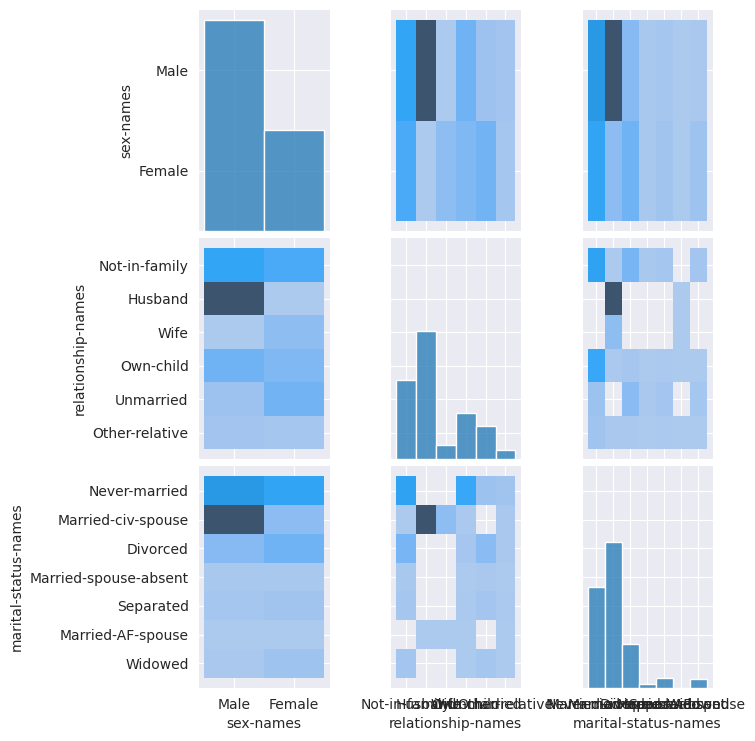

In [37]:
%%capture --no-stdout --no-display
for var in ("sex", "relationship", "marital-status", "occupation", "workclass"):
    data_df[f"{var}-names"] = data_df[var]
    for i, value in enumerate(Adult.variables[var]):
        data_df[f"{var}-names"].replace(i, value, inplace=True)

sns.pairplot(
    data_df,
    vars=("sex-names", "relationship-names", "marital-status-names"),
    kind="hist",
    plot_kws={"discrete": True, "stat": "frequency"},
)


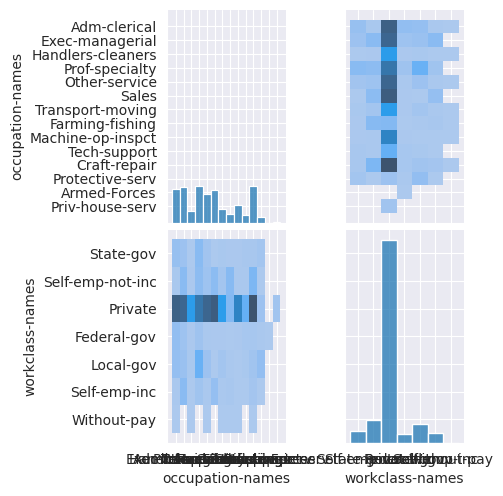

In [38]:
%%capture --no-stdout --no-display

sns.pairplot(
    data_df,
    vars=("occupation-names", "workclass-names"),
    kind="hist",
    plot_kws={"discrete": True, "stat": "frequency"},
)


## Building the Network
We posit `sex` and `native-country`/`native-region` as root variables
of our Bayesian network.

### Influence of root variables on other variables
We take a look at the differences


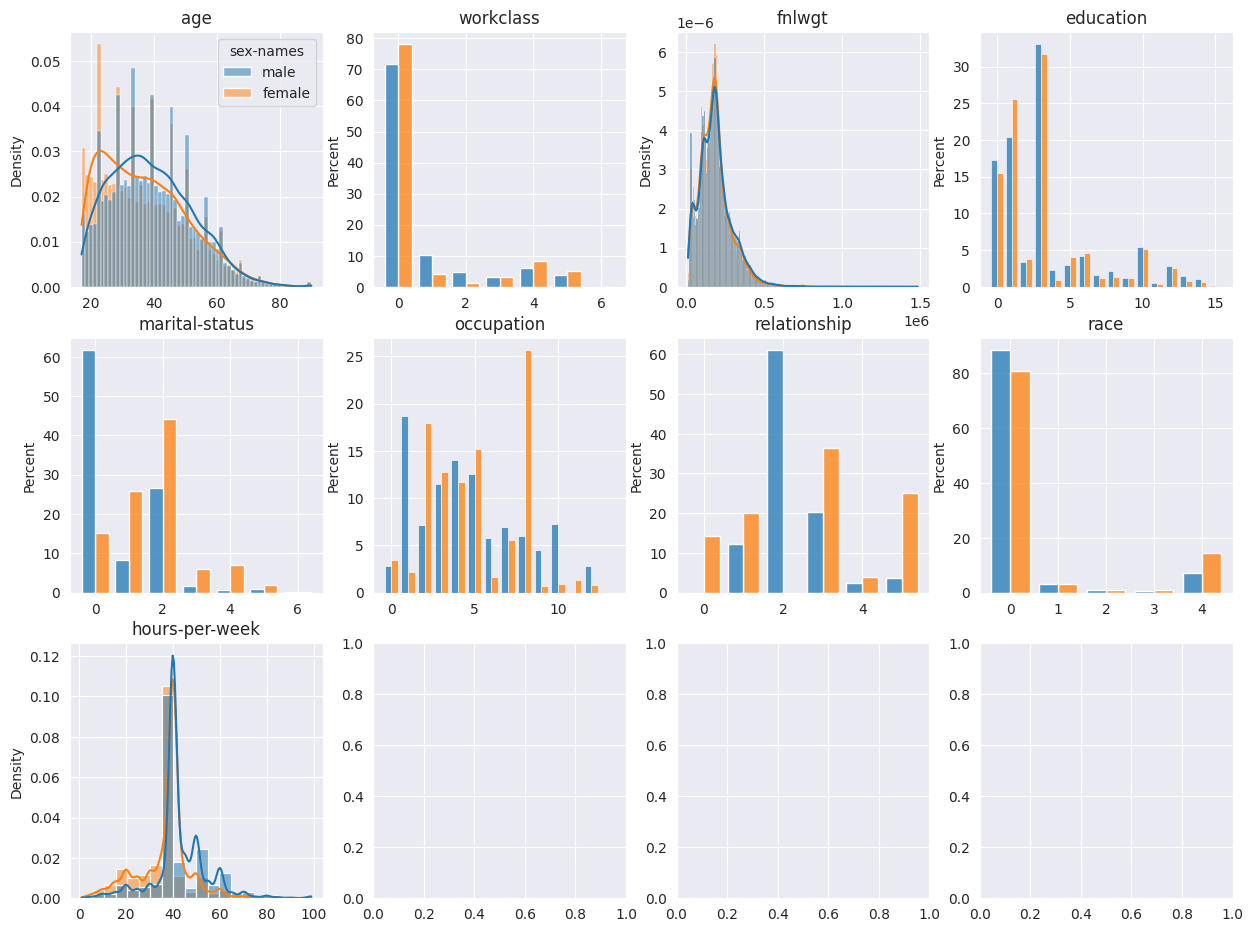

In [28]:
%%capture --no-stdout --no-display
data_df["sex-names"] = data_df["sex"]
data_df["sex-names"].replace(0.0, "female", inplace=True)
data_df["sex-names"].replace(1.0, "male", inplace=True)

fig, axes = plt.subplots(3, 4, figsize=(15, 11.25))
axes = axes.flatten()
vars = [
    var for var in adult_input_space.attribute_names if not var.startswith("capital") and var not in ("sex", "native-country", "education-num")
]
for var, ax in zip(vars, axes):
    ax.set_title(var)
    # categorical variables
    if var in (
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
    ):
        g = sns.histplot(
            data_df,
            x=var,
            hue="sex-names",
            discrete=True,
            common_norm=False,
            shrink=0.8,
            multiple="dodge",
            stat="percent",
            ax=ax,
            legend=False,
        )
    else:
        kwargs = {}
        if var == "hours-per-week":
            kwargs["bins"] = 20
        g = sns.histplot(
            data_df,
            x=var,
            hue="sex-names",
            stat="density",
            common_norm=False,
            kde=True,
            legend=var=="age",
            ax=ax,
            **kwargs,
        )
    g.set(xlabel=None)


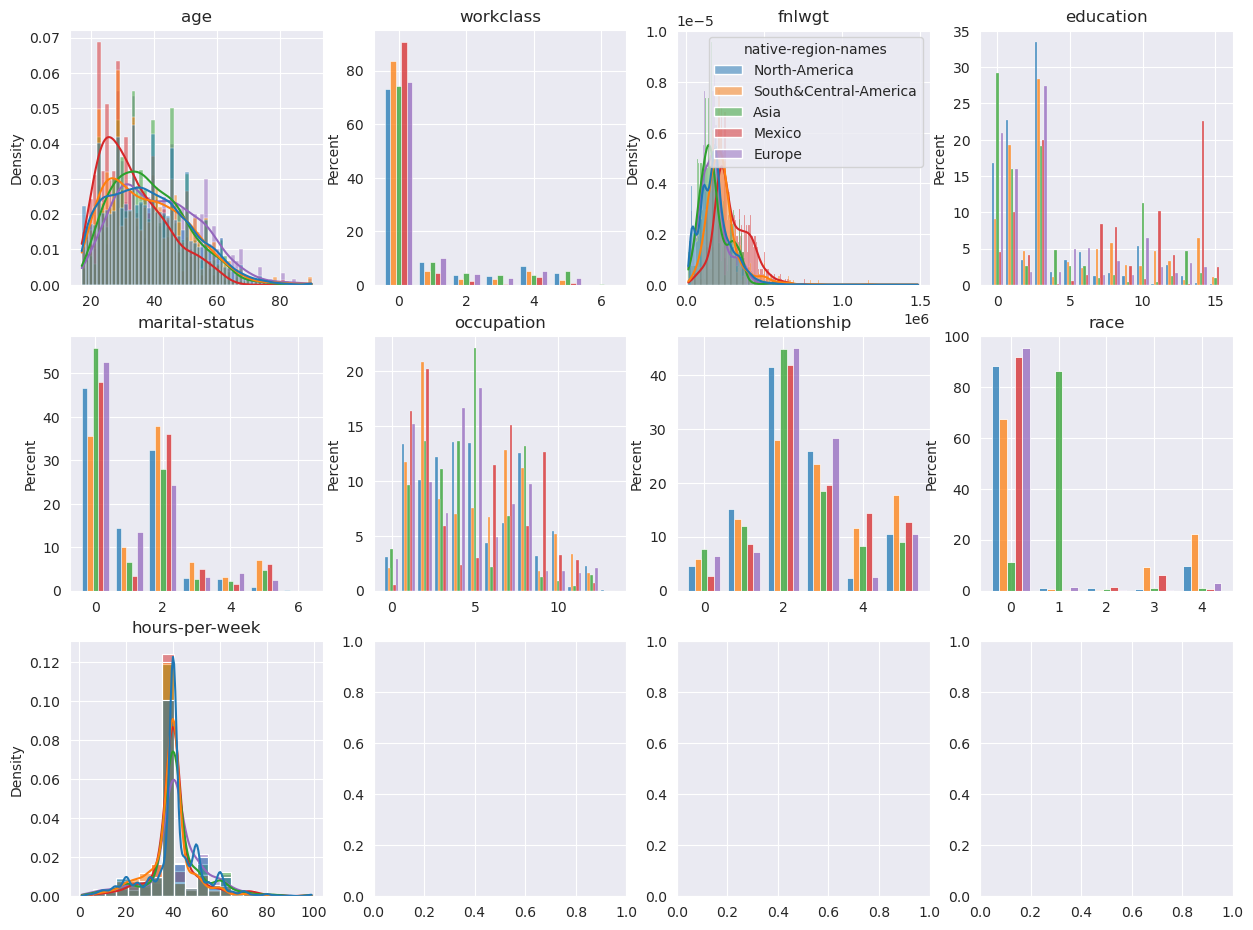

In [118]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(3, 4, figsize=(15, 11.25))
axes = axes.flatten()
vars = [
    var for var in adult_input_space.attribute_names if not var.startswith("capital") and var not in ("sex", "native-country", "education-num")
]
for var, ax in zip(vars, axes):
    ax.set_title(var)
    # categorical variables
    if var in (
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
    ):
        g = sns.histplot(
            data_df,
            x=var,
            hue="native-region-names",
            discrete=True,
            common_norm=False,
            shrink=0.8,
            multiple="dodge",
            stat="percent",
            legend=False,
            ax=ax,
        )
    else:
        kwargs = {}
        if var == "hours-per-week":
            kwargs["bins"] = 20
        g = sns.histplot(
            data_df,
            x=var,
            hue="native-region-names",
            stat="density",
            common_norm=False,
            kde=True,
            legend=var=="fnlwgt",
            ax=ax,
            **kwargs,
        )
    g.set(xlabel=None)



## Building the Network
We posit sex and native-country as root variables of our network.
In a first step, we model race depending on sex and native-country (grouped by region)



Our causal graph is as follows:
- sex and native-country are root cause variables.
  We assume that sex and native-country are independent. 
  In reality, sex and native-country may not be independent, for example,
  due to gender imbalances among the people immigrating to the US.
  Since this appears to be irrelevant in the data, we choose not to model
  potential causation between sex and native-country.
- race has native-country as a cause (together with other unobserved effects). 
- age has sex, race, and native-country as causes (+ unobserved effects).
- we include an unobserved variable "unobserved1" as a root cause. 
  This variable is determined though clustering. 
- education has sex, race, age, and native-country as causes
  (+ unobserved effects, omitted in the following)
- education-num is determined by education entirely
- All remaining variables have all of the above variables as causes 
  (excluding education-num as it duplicates education).
- Some of these variables, such as occupation and relationship might have (circular)
  interactions, that we choose not to model.
- We treat capital-gain and capital-loss specially, as they are complementary variables.
  The variables capital-gain and capital-loss are determined entirely by an
  auxiliary variable capital-change that is the sum of capital-loss and capital-gain.
  Now, capital-gain is simply capital-chance if capital-change is positive and 0.0
  otherwise. 
  Similarly, capital-loss is capital-change if capital-change is negative and
  0.0 otherwise.


In [ ]:
causal_graph = OrderedDict(
    [
        ("sex", []),
        ("native-country", []),
        ("race", ["native-country"]),
        ("age", ["sex", "race", "native-country"]),
        ("education", ["sex", "race", "native-country", "age"]),
        ("education-num", ["education"]),
        (
            "occupation",
            ["sex", "race", "native-country", "age", "education"],
        ),
        (
            "workclass",
            ["sex", "race", "native-country", "age", "education"],
        ),
        (
            "hours-per-week",
            ["sex", "race", "native-country", "age", "education"],
        ),
        (
            "marital-status",
            ["sex", "race", "native-country", "age", "education"],
        ),
        (
            "relationship",
            ["sex", "race", "native-country", "age", "education"],
        ),
        (
            "fnlwgt",
            ["sex", "race", "native-country", "age", "education"],
        ),
        (
            "capital-change",
            ["sex", "race", "native-country", "age", "education"],
        ),
    ]
)

capital_chance = (
    dataset.data[:, col_idx["capital-gain"]] - dataset.data[:, col_idx["capital-loss"]]
)
data = torch.hstack([dataset.data, capital_chance])
test_capital_chance = (
    test_set.data[:, col_idx["capital-gain"]]
    - test_set.data[:, col_idx["capital-loss"]]
)
test_data = torch.hstack([test_set.data, test_capital_chance])

### Build the linear models

In [ ]:
def fit_continuous(effect_var, cause_vars):
    cause_idx = list(chain(*[col_idx[var] for var in cause_vars]))
    inputs = data[:, cause_idx]
    target = data[:, col_idx[effect_var]]
    regressor = Ridge()
    regressor.fit(inputs, target)

    train_score = regressor.score(inputs, target)
    inputs = test_data[:, cause_idx]
    target = test_data[:, col_idx[effect_var]]
    test_score = regressor.score(inputs, target)
    print()
    print(f"{effect_var} <- {cause_vars}")
    print(f"R-Squared (Train): {train_score:.4f}")
    print(f"R-Squared (Test):  {test_score:.4f}")

    return regressor


def fit_categorical(effect_var, cause_vars):
    cause_idx = list(chain(*[col_idx[var] for var in cause_vars]))
    inputs = data[:, cause_idx]
    target = dataset_raw.data[:, col_raw_id[effect_var]]
    classifier = LogisticRegression(
        class_weight="balanced",
        multi_class="multinomial",
        max_iter=600,
    )
    classifier.fit(inputs, target)

    train_score = classifier.score(inputs, target)
    inputs = test_data[:, cause_idx]
    target = test_data_raw.data[:, col_raw_id[effect_var]]
    test_score = classifier.score(inputs, target)
    print()
    print(f"{effect_var} <- {cause_vars}")
    print(f"Accuracy (Train): {train_score:.4f}")
    print(f"Accuracy (Test):  {test_score:.4f}")

    return classifier


predictors = {}
for var, causes in causal_graph.items():
    if len(causes) > 0:
        if len(col_idx[var]) == 1:
            predictors[var] = fit_continuous(var, causes)
        else:
            predictors[var] = fit_categorical(var, causes)

### Fit probability distributions to residuals
For continuous variables, we fit normal distributions to the residuals.
For categorical variables, we fit multinoulli (multi-class Bernoulli) distributions.


In [ ]:
def distribution_continuous(residuals_, var):
    mean_ = residuals_.mean().item()
    std_ = residuals_.std().item()
    var_i = adult_input_space.attribute_names.index(var)
    # TODO: not the same space + a, b should be in multiples of std-devs
    min_, max_ = adult_input_space.attribute_bounds(var_i)
    print(var, var_i, min_, max_, mean_, std_)
    return truncnorm(a=min_, b=max_, loc=mean_, scale=std_)


def get_gaussian_mixture(residuals_, n_components):
    mixture_model = GaussianMixture(
        n_components,
        covariance_type="spherical",
        n_init=5,
    )
    mixture_model.fit(residuals_)
    return mixture_model


def distribution_categorical(residuals_, is_root_cause=False):
    class_frequencies = residuals_.mean(dim=0).tolist()
    abstain_frequency = 1.0 - sum(class_frequencies)
    if not is_root_cause:
        class_frequencies += [abstain_frequency]
    return multinomial(n=1, p=class_frequencies)


distributions = {}
for var, causes in causal_graph.items():
    residuals = data[:, col_idx[var]]
    if len(causes) > 0:
        cause_values = data[:, list(chain(*[col_idx[var] for var in causes]))]
        if len(col_idx[var]) == 1:  # continuous
            predictions = predictors[var].predict(cause_values)
            residuals = residuals - predictions
        else:  # categorical
            predictions = predictors[var].predict_proba(cause_values)
            predictions = torch.as_tensor(predictions)
            max_probabilities = torch.amax(predictions, dim=1)
            predictions_one_hot = predictions == max_probabilities.unsqueeze(-1)
            # keep original class if predictor errs, otherwise set residual
            # for a sample to all zero
            residuals = torch.clip(residuals - predictions_one_hot.float(), min=0.0)
    if var == "capital-change":
        distributions[var] = get_gaussian_mixture(residuals, n_components=5)
    elif len(col_idx[var]) == 1:
        distributions[var] = distribution_continuous(residuals, var)
    else:
        distributions[var] = distribution_categorical(
            residuals, is_root_cause=len(causes) == 0
        )

### Compare the data distribution with the distribution of the population model


In [ ]:
n = 10000
generated = {}
for var, causes in tqdm(causal_graph.items()):
    if len(col_idx[var]) == 1:
        if len(causes) == 0:
            var_data = torch.as_tensor(distributions[var].rvs(n))
        else:
            cause_values = torch.hstack([generated[cause] for cause in causes])
            predicted = predictors[var].predict(cause_values)
            predicted = torch.as_tensor(predicted)
            if isinstance(distributions[var], GaussianMixture):
                gmm = distributions[var]
                select_normal = multinomial.rvs(n=1, p=gmm.weights_, size=n)
                select_normal = torch.as_tensor(select_normal)
                normally_distributed = torch.hstack(
                    [
                        torch.as_tensor(
                            norm.rvs(
                                loc=mean_,
                                scale=var_,
                                size=(n, 1),
                            )
                        )
                        for mean_, var_ in zip(gmm.means_, gmm.covariances_)
                    ]
                )
                residual = torch.masked_select(
                    normally_distributed, select_normal.bool()
                )
                residual = residual.reshape(n, 1)
            else:
                residual = distributions[var].rvs((n, 1))
                residual = torch.as_tensor(residual)
            var_data = predicted + residual
    else:
        residual = distributions[var].rvs(n)
        residual = torch.as_tensor(residual)
        if len(causes) == 0:
            var_data = residual
        else:
            residual = residual[:, :-1]  # drop abstain column
            cause_values = torch.hstack([generated[cause] for cause in causes])
            predicted = predictors[var].predict_proba(cause_values)
            predicted = torch.as_tensor(predicted)
            var_data = predicted + residual
        max_values = torch.amax(var_data, dim=1)
        var_data = (var_data == max_values.unsqueeze(-1)).float()
    generated[var] = var_data

# compute capital gain and capital loss
capital_gain = torch.clip(generated["capital-change"], min=0)
capital_loss = -torch.clip(generated["capital-change"], max=0)
generated["capital-gain"] = capital_gain
generated["capital-loss"] = capital_loss

In [ ]:
generated_raw = {}

# for reversing normalization
means = torch.mean(dataset_raw.data, dim=0)
stds = torch.std(dataset_raw.data, dim=0)
for i, var in enumerate(adult_input_space.attribute_names):
    if len(col_idx[var]) == 1:
        generated_raw[var] = stds[i] * generated[var].squeeze() + means[i]
    else:
        # convert all one-hot encodings to value indices
        var_one_hot = generated[var]
        var_values = torch.argmax(var_one_hot, dim=1)
        generated_raw[var] = var_values

generated_df = pd.DataFrame(generated_raw)
data_df = pd.DataFrame(dataset_raw.data, columns=dataset_raw.columns)
# test_data_df = pd.DataFrame(test_data_raw.data, columns=test_data_raw.columns)

generated_df["dataset"] = "generated"
data_df["dataset"] = "train"
# test_data_df["dataset"] = "test"
df = pd.concat([generated_df, data_df])

#### Plot Marginal Distributions

In [ ]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(3, 4, figsize=(15, 11.25))
axes = axes.flatten()
vars = [
    var for var in adult_input_space.attribute_names if not var.startswith("capital")
]
for var, ax in zip(vars, axes):
    ax.set_title(var)
    if len(col_idx[var]) > 1 or var == "education-num":
        kwargs = {}
        kwargs["legend"] = var == "native-country"
        g = sns.histplot(
            df,
            x=var,
            hue="dataset",
            discrete=True,
            shrink=0.8,
            multiple="dodge",
            stat="percent",
            common_norm=False,
            ax=ax,
            **kwargs,
        )
    else:
        kwargs = {}
        if var == "hours-per-week":
            kwargs["bins"] = 25
        g = sns.histplot(
            df,
            x=var,
            hue="dataset",
            legend=False,
            stat="density",
            common_norm=False,
            kde=True,
            ax=ax,
            **kwargs,
        )
    g.set(xlabel=None)

In [ ]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for var, ax in zip(("capital-gain", "capital-loss"), axes):
    ax.set_title(var)
    sns.histplot(
        df,
        x=var,
        hue="dataset",
        legend=False,
        stat="density",
        common_norm=False,
        log_scale=(False, True),
        bins=100,
        ax=ax,
    )

#### Plot Correlation Matrix


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))

axes[0].set_title("Generated")
generated_df_ = generated_df.drop("dataset", axis=1)
sns.heatmap(
    np.corrcoef(generated_df_.to_numpy().T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
    ax=axes[0],
)
axes[1].set_title("Training Data")
sns.heatmap(
    torch.corrcoef(dataset_raw.data.T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
    ax=axes[1],
)

# Build Population Models

## Factor Analysis Population Model
Based on Factor Analysis: The factors are uncorrelated jointly normally distributed with mean zero, zero covariance and variance 1.
Similarly, the noise terms are jointly normally distributed with zero mean, zero covariance and certain fixed variances.
Since the factors and noise terms are jointly normally distributed and uncorrelated, they are independent.

In [ ]:
W = factor_analysis.components_
W

In [ ]:
eps_var = factor_analysis.noise_variance_
np.atleast_2d(eps_var)

In [ ]:
# Truncate normal distributions after four standard deviations.
# Covers >0.9999 of the probability mass of a regular normal distribution.
ran = 4.0
factor_distributions = [
    ContinuousDistribution1d(truncnorm(a=-ran, b=ran, loc=0.0, scale=1.0))
    for _ in range(W.shape[0])
]
noise_std = np.sqrt(eps_var)
noise_distributions = [
    ContinuousDistribution1d(truncnorm(a=-ran * std, b=ran * std, loc=0.0, scale=std))
    for std in noise_std
]
factor_analysis_distribution = MultidimensionalIndependent(
    *(factor_distributions + noise_distributions),
    input_shape=(W.shape[0] + eps_var.shape[0],)
)

factor_analysis_input_space = TensorInputSpace(
    lbs=torch.tensor([-ran] * W.shape[0] + (-ran * noise_std).tolist()),
    ubs=torch.tensor([ran] * W.shape[0] + (ran * noise_std).tolist()),
)

# pick 0.0 means for categorical/one-hot encoded attributes
continuous_mean = torch.tensor(
    [
        mean[i] if isinstance(values, int) else 0.0
        for i, values in enumerate(adult_input_space.encoding_layout.values())
        for _ in ((None,) if isinstance(values, int) else values)
    ]
)
continuous_std = torch.tensor(
    [
        std[i] if isinstance(values, int) else 1.0
        for i, values in enumerate(adult_input_space.encoding_layout.values())
        for _ in ((None,) if isinstance(values, int) else values)
    ]
)

from_factors_and_noise = FactorAnalysisModel(factor_loadings=torch.as_tensor(W).T)
mean_, std_ = torch.atleast_2d(mean, std)
denormalize = Denormalize(mean_, std_)
encode_one_hot = EncodeOneHot(
    [
        None if isinstance(values, int) else len(values)
        for values in adult_input_space.encoding_layout.values()
    ]
)
continuous_mean, continuous_std = torch.atleast_2d(continuous_mean, continuous_std)
normalize = Normalize(continuous_mean, continuous_std)
factor_analysis_population_model = nn.Sequential(
    from_factors_and_noise,
    denormalize,
    encode_one_hot,
    normalize,
    Identity(105),  # provide explicit shape information for auto_LiRPA
)

Investigate some empirical properties of the factor analysis population model

In [ ]:
n = len(dataset)

factors = torch.randn((n, W.shape[0]))
noise = torch.randn((n, eps_var.shape[0])) * noise_std
x = torch.hstack([factors, noise]).float()
z = factor_analysis_population_model(x)
z_denorm = z * continuous_std + continuous_mean

print("Attribute                  | Population Model | Data")
print("------------------------------------------------------")
frac_female_pop_model = z[:, adult_input_space.encoding_layout["sex"]["Female"]].mean()
frac_male_pop_model = z[:, adult_input_space.encoding_layout["sex"]["Male"]].mean()
sex_data = dataset.data[:, list(adult_input_space.encoding_layout).index("sex")]
frac_female_data = (sex_data == 0.0).float().mean()
frac_male_data = (sex_data == 1.0).float().mean()
print("Sex                        |                  |")
print(
    f"Female                     | {frac_female_pop_model:5.4f}           | {frac_female_data:.4f}"
)
print(
    f"Male                       | {frac_male_pop_model:5.4f}           | {frac_male_data:.4f}"
)
print("Race                       |                  |")
race_data = dataset.data[:, list(adult_input_space.encoding_layout).index("race")]
for i, edu_val in enumerate(
    adult_input_space.attribute_values(adult_input_space.attribute_names.index("race"))
):
    frac_pop_model = z[:, adult_input_space.encoding_layout["race"][edu_val]].mean()
    frac_data = (race_data == i).float().mean()
    print(f"{edu_val:26} | {frac_pop_model:5.4f}           | {frac_data:5.4f}")
print("Age                        |                  |")
age_data = dataset.data[:, list(adult_input_space.encoding_layout).index("age")]
for threshold in range(0, 110, 20):
    frac_pop_model = (
        (z_denorm[:, adult_input_space.encoding_layout["age"]] <= threshold)
        .float()
        .mean()
    )
    frac_data = (age_data <= threshold).float().mean()
    print(
        f"age <= {threshold:3}                 | {frac_pop_model:5.4f}           | {frac_data:5.4f}"
    )
# education
print("Education                  |                  |")
edu_data = dataset.data[:, list(adult_input_space.encoding_layout).index("education")]
for i, edu_val in enumerate(
    adult_input_space.attribute_values(
        adult_input_space.attribute_names.index("education")
    )
):
    frac_pop_model = z[
        :, adult_input_space.encoding_layout["education"][edu_val]
    ].mean()
    frac_data = (edu_data == i).float().mean()
    print(f"{edu_val:26} | {frac_pop_model:5.4f}           | {frac_data:5.4f}")

## Independent Variables Population Model
Assume that continuous variables are normally distributed
while categorical variables are multinomially distributed.


In [ ]:
# We truncate normal distributions after four standard deviations as
# for the factor analysis population model
ran = 4.0


def get_continuous(i):
    mean_ = mean[i]
    std_ = std[i]
    return ContinuousDistribution1d(
        truncnorm(a=-ran * std, b=ran * std, loc=mean_, scale=std_)
    )


def get_categorical(i, num_values):
    values = dataset.data[:, i]  # not normalised
    frequencies = [(values == k).float().mean() for k in range(num_values)]
    return DiscreteDistribution1d(multinomial(n=1, p=np.array(frequencies)))


distributions = []
for i, attr_type in enumerate(adult_input_space.attribute_types):
    match attr_type:
        case TabularInputSpace.AttributeType.CONTINUOUS:
            distr = get_continuous(i)
        case TabularInputSpace.AttributeType.ORDINAL:
            # only fnlwgt is ordinal, which starts from 0
            distr = get_categorical(i, adult_input_space.attribute_bounds(i)[1] + 1)
        case TabularInputSpace.AttributeType.CATEGORICAL:
            distr = get_categorical(i, len(adult_input_space.attribute_values(i)))
        case _:
            raise NotImplementedError()
    distributions.append(distr)
independent_distribution = MultidimensionalIndependent(
    *distributions, input_shape=(len(distributions),)
)

## Save the population models

In [ ]:
with open("../../resources/adult/factor_analysis_distribution.dill", "wb") as file:
    dill.dump(factor_analysis_distribution, file)
with open("../../resources/adult/factor_analysis_input_space.dill", "wb") as file:
    dill.dump(factor_analysis_input_space, file)
torch.save(
    factor_analysis_population_model,
    "../../resources/adult/factor_analysis_population_model.pyt",
)